In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import metrics

In [2]:
# load data
data = pd.read_csv('./clean_data2.csv')

# separate x and y
y_label = 'CMI:75 F3a) Epilepsy: Ever suffered'
y_df = data[y_label].copy()
x_df = data.drop(y_label, axis = 1)

In [6]:
# if more than 15 unique values, then treated as numerical
master_list = []

for col in x_df.columns:
    # get unique count
    unique_count = len(x_df[col].unique())
    
    # numerical variable
    if unique_count > 15:
        # get a copy for processing
        curr_df = x_df[col].copy()
        # handle NaN
        curr_df[curr_df.isnull()] = -1
        # standardize
        curr_df = pd.DataFrame(preprocessing.scale(curr_df.values))
        # reset index
        curr_df.index = x_df.index
        # append to master list
        master_list.append(curr_df)
    # categorical variable
    else:
        # get a copy
        curr_df = x_df[col].copy()
        # get dummy
        # if contains NaN
        if curr_df.isnull().values.any():
            dummy = pd.get_dummies(curr_df, dummy_na = True)
        # if no NaN
        else:
            dummy = pd.get_dummies(curr_df, dummy_na = False)
        # reset columns
        dummy.columns = [str(col)+'='+str(value) for value in dummy.columns]
        # reset index
        dummy.index = x_df.index
        # append to master list
        master_list.append(dummy)
        
# concatenate master list
x_df_extended = pd.concat(master_list, axis = 1)

print 'data shape before dummification/standardization', x_df.shape
print 'data shape after dummification/standardization', x_df_extended.shape

# for y_df
# 1: have epilepsy
# 2: have epilepsy only when pregnant
# 3: not have epilepsy

mask_0 = y_df == 3
y_df_masked = y_df.copy()
y_df_masked[mask_0] = 0
y_df_masked[~mask_0] = 1

data shape before dummification/standardization (11326, 1449)
data shape after dummification/standardization (11326, 7500)


In [7]:
# train test split
x_train, x_test, y_train, y_test = cross_validation.train_test_split(\
    x_df_extended.values, y_df_masked.values)

# build model
lr_model = linear_model.LogisticRegressionCV()

# train model
lr_model.fit(x_train, y_train)

# predict
y_test_predict_proba = lr_model.predict_proba(x_test)[:, 0]
threshold = 0.999
mask_0 = y_test_predict_proba > threshold
y_test_predict = np.ones(y_test_predict_proba.shape)
y_test_predict[mask_0] = 0

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_predict)
cm_df = pd.DataFrame(cm, columns = ['predict 0', 'predict 1'], index = ['true 0', 'true 1'])

# score
accuracy_all = float(sum(y_test_predict == y_test))/float(len(y_test))
accuracy_healthy = float(cm[0,0])/float(cm[0,0]+cm[0,1])
accuracy_epilepsy = float(cm[1,1])/float(cm[1,0]+cm[1,1])

# output
print 'accuracy overall: %.3f' % accuracy_all
print 'accuracy on healthy patients: %.3f' % accuracy_healthy
print 'accuracy on epilepsy patients: %.3f' % accuracy_epilepsy
cm_df

accuracy overall: 0.017
accuracy on healthy patients: 0.001
accuracy on epilepsy patients: 1.000


,predict 0,predict 1
true 0,4,2784
true 1,0,44


In [50]:
coef[most_pos_var_index]

array([ 0.05576308,  0.05590514,  0.05611855,  0.05626725,  0.05718956,
        0.05741823,  0.05778038,  0.05807037,  0.05839064,  0.05842772,
        0.0593606 ,  0.06167377,  0.06252112,  0.06295056,  0.0637245 ,
        0.0640273 ,  0.06571124,  0.06678088,  0.06682674,  0.06688824,
        0.06763165,  0.06771956,  0.06826298,  0.06982302,  0.07019754,
        0.07108686,  0.07716343,  0.08091512,  0.10540627,  0.14383961])

In [51]:
len(coef[most_pos_var_index])

30

In [53]:
# get coefficient
coef = lr_model.coef_.flatten()

most_pos_var_index = np.argsort(coef)[-30:]
most_neg_var_index = np.argsort(coef)[0:3]

most_pos_var = x_df_extended.columns.values[most_pos_var_index]
most_neg_var = x_df_extended.columns.values[most_neg_var_index]

print 'most positive variables'
print most_pos_var
print 'most negative variables'
print most_neg_var

most positive variables
['CMI:75 F3a) Persistent mouth/gum trouble: Ever suffered=2.0'
 'CMI:75 F3a) Hay fever: Ever suffered=2.0'
 'CMI:75 F3a) Migraine: Ever suffered=2.0'
 '2P Difficulty settling to anything=2.0'
 '2P Ever seen specialist-convulsions,fits=2.0' 0 0
 '2P Reason for prescription  M:C 1-2=1.0' 0 0
 'CMI:75 F3a) Diabetes: Ever suffered=2.0'
 'CMI:75 F3a) Kidney/bladder trouble: Ever suffered=2.0'
 'CMI:75 F3a) Eczema/other skin problem:Ever suffered=2.0'
 '1D Defects found in NCDS1 sample-MC 1:4=3.0' 0
 'CMI:81 F31 Disability affects kind/amount of paid work done=1.0'
 'CMI:75 F3a) Dizziness/unsteadiness: Ever suffered=1.0'
 'CMI:75 F3a) Heart trouble: Ever suffered=2.0'
 'CMI:75 F3a) Gall bladder trouble: Eversuffered=2.0'
 'CMI:75 F3a) Hernia: Ever suffered=2.0'
 '3M Abnormal neuromuscular,logical system=1.0'
 '3P Is child handicapped or disabled=1.0' 0 0
 'CMI:81 F30 Disability makes it harder to get/keep a paid job=1.0'
 '3P Convulsions-most recent occurrence=7.0'
 '

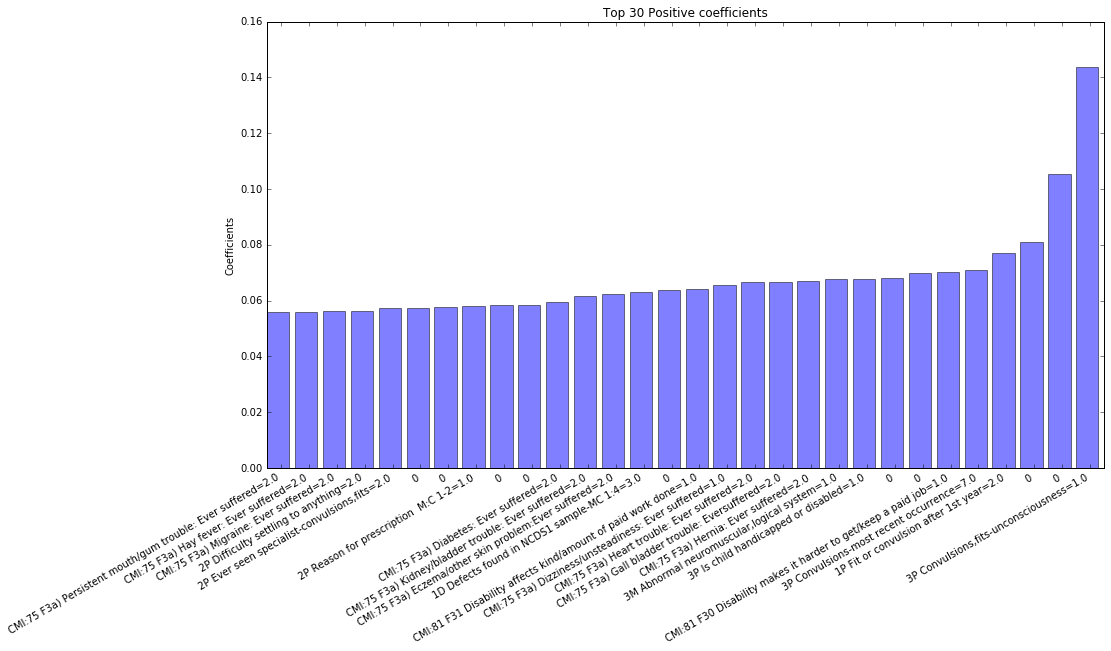

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

n = 30
#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5

#Bar plot of the frequencies of the top words
ax.bar(indices, coef[most_pos_var_index], color='blue', alpha=0.5)

ax.set_ylabel('Coefficients')
ax.set_title('Top ' + str(n) + " Positive coefficients")

# #Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels(most_pos_var)

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10,ha = "right")

plt.show()
fig.savefig("Impor_featr.jpg")